### Project Overview

Accidents resulting from defective railway tracks and derailments are a frequent and serious concern, especially in Southeast Asian countries. Early and accurate detection of track faults is critical to prevent such disasters. However, manual inspection methods are often time-consuming, labor-intensive, and expensive.

To address this, a series of four notebooks were developed to explore different automated fault detection approaches, using a publicly available railway track dataset from Kaggle:  
[Railway Track Fault Detection Dataset](https://www.kaggle.com/datasets/salmaneunus/railway-track-fault-detection).

1. Classical Machine Learning:  
   Using traditional techniques such as Support Vector Machine (SVM), Logistic Regression, and Random Forest classifiers on hand-crafted HOG features.

2. CNN-based Classification (without Augmentation):
   Training convolutional neural network models on the original dataset to classify defective and non-defective railway tracks.

3. **CNN-based Classification (with Data Augmentation)(This Notebook)**:
   Enhancing the training data through augmentation techniques to improve model generalization and robustness.

4. Anomaly Detection using Autoencoder:
   Training a UNet-style convolutional autoencoder exclusively on healthy track images and detecting faults based on reconstruction error analysis.

This multi-approach study provides a comprehensive evaluation of both classical and deep learning methods for automatic railway track fault detection.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Core Python Libraries
import os
import sys
import gc
import random as rnd
import warnings
import pickle

# Progress Bar
from tqdm import tqdm

# Data Handling and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
import cv2
from PIL import Image
from skimage import color, exposure
from skimage.feature import hog, canny
from skimage.filters import sobel
from skimage.transform import rotate, rescale, AffineTransform, warp
from skimage.util import random_noise

# Machine Learning (Scikit-learn)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Activation, Flatten,
    BatchNormalization, Conv2D, MaxPooling2D,
    AveragePooling2D, GlobalAveragePooling2D
)
from tensorflow.keras.applications import (
    VGG16, ResNet50, MobileNetV2, EfficientNetB0, InceptionResNetV2
)
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
import keras.backend as K
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Training Progress Visualization
try:
    from livelossplot import PlotLossesKeras
except ImportError:
    !pip install livelossplot
    from livelossplot import PlotLossesKeras

# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


## Dataset Organization

The dataset consists of railway track images categorized into two classes: Defective and Non-defective.
The images are split into three subsets:
- Train set
- Validation set
- Test set

Each subset contains separate folders for defective and non-defective samples.  
The number of samples in each category and subset was printed to verify correct dataset loading.

Additionally, all defective and non-defective samples across train, validation, and test sets were concatenated into two combined DataFrames (defective and undefective) for further analysis and visualization.


### Dataset Split Summary

The dataset was evenly split between defective and undefective railway track images across training, validation, and test sets:

- Training set: 150 defective and 150 undefective samples
- Validation set: 31 defective and 31 undefective samples
- Test set: 11 defective and 11 undefective samples

This balanced split ensures that both classes are equally represented during model training and evaluation, minimizing bias and providing a fair assessment of performance.

In [ ]:
train_path = '../input/railway-track-fault-detection/Railway Track fault Detection Updated/Train'
val_path = '../input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation'
test_path = '../input/railway-track-fault-detection/Railway Track fault Detection Updated/Test'

In [ ]:
train_df_defective = pd.DataFrame(os.listdir(train_path+'/Defective'))
val_df_defective = pd.DataFrame(os.listdir(val_path+'/Defective'))
test_df_defective = pd.DataFrame(os.listdir(test_path+'/Defective'))
train_df_undefective = pd.DataFrame(os.listdir(train_path+'/Non defective'))
val_df_undefective = pd.DataFrame(os.listdir(val_path+'/Non defective'))
test_df_undefective = pd.DataFrame(os.listdir(test_path+'/Non defective'))

In [ ]:
defective=pd.concat([train_df_defective,test_df_defective,val_df_defective], axis=0)
undefective=pd.concat([train_df_undefective,test_df_undefective,val_df_undefective], axis=0)

In [ ]:
# Print the number of defective and undefective samples in the training, validation, and test sets
print('Train samples defective: ', len(train_df_defective))
print('Val samples defective: ', len(val_df_defective))
print('Test samples defective: ', len(test_df_defective))
print()
print('Train samples undefective: ', len(train_df_undefective))
print('Val samples undefective: ', len(val_df_undefective))
print('Test samples undefective: ', len(test_df_undefective))

In [ ]:
# Define data
categories = ['Train', 'Validation', 'Test']
defective_counts = [len(train_df_defective), len(val_df_defective), len(test_df_defective)]
undefective_counts = [len(train_df_undefective), len(val_df_undefective), len(test_df_undefective)]

# Set up bar positions
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Plot
fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, defective_counts, width, label='Defective')
rects2 = ax.bar(x + width/2, undefective_counts, width, label='Non-defective')

# Add labels, title and legend
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Defective and Non-defective Samples')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Add value labels on bars
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
# Display the first 31 defective training images after resizing them to 448x448 and print their original dimensions
plt.figure(figsize=(15, 12))
for idx, image_path in enumerate(train_df_defective[0]):
    if idx == 31:
        break
    plt.subplot(4, 8, idx + 1)

    # Read the image with OpenCV
    img = cv2.imread('../input/railway-track-fault-detection/Railway Track fault Detection Updated/Train/Defective/' + image_path)

    # OpenCV loads images in BGR format, so convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, channels = img.shape

    print(f"Width: {width}, Height: {height}, Channels: {channels}")
    #Resize the image
    img = cv2.resize(img, (448, 448))

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(idx)

plt.tight_layout()
plt.show()


In [ ]:
# Display the first 31 undefective training images after resizing them to 448x448 for visual inspection
plt.figure(figsize=(15, 12))
for idx, image_path in enumerate(train_df_undefective[0]):
    if idx == 31:
        break
    plt.subplot(4, 8, idx + 1)

    # Read the image with OpenCV
    img = cv2.imread('../input/railway-track-fault-detection/Railway Track fault Detection Updated/Train/Non defective/' + image_path)

    # OpenCV loads images in BGR format, so convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image
    img = cv2.resize(img, (448, 448))

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(idx)

plt.tight_layout()
plt.show()


## Data Augmentation Strategy

To improve the model's generalization ability and reduce overfitting, extensive data augmentation was applied to both defective and non-defective training images.

The following augmentation techniques were used:
- Random Rotation: Rotating images randomly between -40° to 40°.
- Horizontal Flip: Mirroring the image along the vertical axis.
- Vertical Flip: Flipping the image along the horizontal axis.
- Random Noise: Adding Gaussian random noise to simulate sensor imperfections.
- Brightness Adjustment: Applying random gamma corrections for varying lighting conditions.
- Random Shearing: Distorting the image geometrically by a small shear angle.
- Random Zoom: Zooming into the image randomly by 10%–30% and cropping back to original size.
-

After applying data augmentation techniques, the final size of the training set increased to 2400 samples with image dimensions 448 × 448 × 3, and corresponding one-hot encoded labels.

No augmentation was carried out on the validation and test sets.  
This ensures that model evaluation remains unbiased and accurately reflects the model's performance on unseen, real-world data.

Each original image generated seven additional augmented versions, significantly expanding the size and diversity of the training set.

All images were normalized to have pixel values in the range [0, 1] before training.
bold text


In [ ]:
X_train = []
y_train = []

def augment_image(img):
    augmented_images = []

    # 1. Random Rotation
    img_rotated = rotate(img, angle=np.random.uniform(-40, 40), mode='wrap')
    img_rotated = (img_rotated * 255).astype('uint8')
    augmented_images.append(img_rotated)

    # 2. Horizontal Flip
    img_hflip = np.fliplr(img)
    augmented_images.append(img_hflip)

    # 3. Vertical Flip
    img_vflip = np.flipud(img)
    augmented_images.append(img_vflip)

    # 4. Random Noise
    img_noisy = random_noise(img)
    img_noisy = (img_noisy * 255).astype('uint8')
    augmented_images.append(img_noisy)

    # 5. Brightness Adjustment (Gamma Correction)
    img_bright = exposure.adjust_gamma(img, gamma=np.random.uniform(0.7, 1.3))
    img_bright = (img_bright * 255).astype('uint8')
    augmented_images.append(img_bright)

    # 6. Random Shear
    shear_angle = np.deg2rad(np.random.uniform(-20, 20))
    shear_transform = AffineTransform(shear=shear_angle)
    img_sheared = warp(img, shear_transform, mode='wrap')
    img_sheared = (img_sheared * 255).astype('uint8')
    augmented_images.append(img_sheared)

    # 7. Zoom In
    zoom_factor = np.random.uniform(1.1, 1.3)  # Zoom between 10%-30%
    img_zoom = rescale(img, scale=(zoom_factor, zoom_factor), mode='reflect', channel_axis=-1)
    img_zoom = (img_zoom * 255).astype('uint8')

    # Crop back to 448x448
    center_crop = img_zoom[
        (img_zoom.shape[0]//2 - 224):(img_zoom.shape[0]//2 + 224),
        (img_zoom.shape[1]//2 - 224):(img_zoom.shape[1]//2 + 224)
    ]
    center_crop = cv2.resize(center_crop, (448, 448))
    augmented_images.append(center_crop)

    return augmented_images

# Load defective train images
for img_path in tqdm(train_df_defective[0]):
    img = cv2.imread(train_path + '/Defective/' + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (448, 448))

    # Original image
    X_train.append(img)
    y_train.append(1)

    # Augmented images
    augmented_imgs = augment_image(img)
    for aug_img in augmented_imgs:
        X_train.append(aug_img)
        y_train.append(1)

# Load non-defective train images
for img_path in tqdm(train_df_undefective[0]):
    img = cv2.imread(train_path + '/Non defective/' + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (448, 448))

    # Original image
    X_train.append(img)
    y_train.append(0)

    # Augmented images
    augmented_imgs = augment_image(img)
    for aug_img in augmented_imgs:
        X_train.append(aug_img)
        y_train.append(0)

# Convert to numpy arrays and normalize
X_train = np.array(X_train, dtype="float32") / 255.0
y_train = np.array(y_train)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)

print('Final training set size:', X_train.shape, y_train.shape)


In [ ]:
# Load and preprocess the final validation set:
# - Read defective and non-defective validation images
# - Convert from BGR to RGB
# - Resize images to 448x448
# - Normalize pixel values to [0, 1]
# - Assign binary labels (1 for defective, 0 for non-defective)
# - One-hot encode the labels for classification
# - No augmentation applied to keep validation performance realistic

X_val = []
y_val = []

# Load defective validation images
for img_path in tqdm(val_df_defective[0], desc='Loading Defective Validation Images'):
    img = cv2.imread(val_path + '/Defective/' + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (448, 448))
    X_val.append(img)
    y_val.append(1)

# Load non-defective validation images
for img_path in tqdm(val_df_undefective[0], desc='Loading Non-Defective Validation Images'):
    img = cv2.imread(val_path + '/Non defective/' + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (448, 448))
    X_val.append(img)
    y_val.append(0)

# Convert to numpy arrays
X_val = np.array(X_val, dtype="float32") / 255.0   # Only normalize (0–1), NO augmentation
y_val = np.array(y_val)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)

print('Final validation set size:', X_val.shape, y_val.shape)


In [ ]:
# Load and preprocess the final test set:
# - Read defective and non-defective test images
# - Convert from BGR to RGB
# - Resize images to 448x448
# - Normalize pixel values to [0, 1]
# - Assign binary labels (1 for defective, 0 for non-defective)
# - One-hot encode the labels for classification
# - No augmentation applied to keep test evaluation unbiased

X_test = []
y_test = []

# Load defective test images
for img_path in tqdm(test_df_defective[0], desc='Loading Defective Test Images'):
    img = cv2.imread(test_path + '/Defective/' + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (448, 448))
    X_test.append(img)
    y_test.append(1)

# Load non-defective test images
for img_path in tqdm(test_df_undefective[0], desc='Loading Non-Defective Test Images'):
    img = cv2.imread(test_path + '/Non defective/' + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (448, 448))
    X_test.append(img)
    y_test.append(0)

# Convert to numpy arrays and preprocess
X_test = np.array(X_test, dtype="float32") / 255.0
y_test = np.array(y_test)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

print('Final test set size:', X_test.shape, y_test.shape)


In [ ]:
# Visualize the class distribution in the train, validation, and test sets:
# - Convert one-hot encoded labels back to class labels
# - Count the number of defective and non-defective samples in each dataset
# - Create a grouped bar plot to compare class distributions
# - Helps verify dataset balance across splits

# Convert one-hot to class labels
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Count images per class
train_defective = np.sum(y_train_labels == 1)
train_nondefective = np.sum(y_train_labels == 0)

val_defective = np.sum(y_val_labels == 1)
val_nondefective = np.sum(y_val_labels == 0)

test_defective = np.sum(y_test_labels == 1)
test_nondefective = np.sum(y_test_labels == 0)

# Data
datasets = ['Train', 'Validation', 'Test']
defective_counts = [train_defective, val_defective, test_defective]
nondefective_counts = [train_nondefective, val_nondefective, test_nondefective]

x = np.arange(len(datasets))  # Label locations
width = 0.35  # Width of bars

# Plot
plt.figure(figsize=(10,6))
plt.bar(x - width/2, nondefective_counts, width, label='Non-Defective')
plt.bar(x + width/2, defective_counts, width, label='Defective')

# Labels
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Each Dataset')
plt.xticks(x, datasets)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
# Define a function to plot the training history of a model:
# - Plots training and validation accuracy over epochs
# - Plots training and validation loss over epochs
# - Helps visualize model learning progress and detect overfitting or underfitting
# - Takes a Keras history object as input

def plot_training_history(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
# Define a function to evaluate a trained model on the test set:
# - Computes test loss and accuracy
# - Predicts classes on the test set
# - Generates and plots a confusion matrix
# - Prints a detailed classification report (precision, recall, F1-score)
# - Extracts and returns the F1 Macro Score, along with test loss and test accuracy
# - Supports customizable class names for clarity in reports

def evaluate_model(model, X_test, y_test, class_names=['Non-Defective', 'Defective']):
    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    # Extract F1 score (macro average)
    f1_macro = report['macro avg']['f1-score']
    print(f"F1 Macro Score: {f1_macro:.4f}")

    # Return all results
    return test_loss, test_accuracy, f1_macro


In [ ]:
# Define a function to create callbacks for model training:
# - EarlyStopping: stops training when validation loss stops improving, restores the best model weights
# - LearningRateScheduler: applies a cosine decay schedule to gradually reduce the learning rate during training
# - Parameters:
#   - patience: number of epochs with no improvement after which training will be stopped
#   - epochs: total number of training epochs (used for cosine decay calculation)
#   - initial_lr: initial learning rate for the scheduler
# - Returns a list of callbacks to be used during model.fit()

def get_callbacks(patience=8, epochs=50, initial_lr=1e-4):
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )
    def cosine_decay(epoch, lr):
        return initial_lr * (np.cos(np.pi * epoch / epochs) + 1) / 2

    scheduler = LearningRateScheduler(cosine_decay)
    return [early_stopping, scheduler]


## VGG16_Custom Model Architecture

The VGG16_Custom model is based on the VGG16 architecture pretrained on ImageNet.
The top classifier layers of VGG16 were removed (include_top=False), and a custom classification head was added.

Key modifications:
- Freezing all layers initially, then unfreezing the last 5 layers for fine-tuning.
- A Global Average Pooling layer replaces the flattened output.
- Three fully connected Dense layers (512, 256, 128 units) with ReLU activation and L1/L2 regularization were added.
- Dropout layers (0.5 and 0.3) were applied for regularization and to reduce overfitting.
- Final output uses a softmax layer for 2-class classification (defective vs non-defective).

The model was compiled using the Adam optimizer with an initial low learning rate 1e-4 ,then varied using the cosine scheduler and trained using categorical crossentropy loss.


In [ ]:
def build_vgg16_custom(input_shape=(448, 448, 3), num_classes=2, base_trainable_layers=5):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-base_trainable_layers:]:
        layer.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu', kernel_regularizer=l1_l2(1e-5, 1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l1_l2(1e-5, 1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l1_l2(1e-5, 1e-4))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs, name="VGG16_Custom")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


## ResNet50_Custom Model Architecture

The ResNet50_Custom model is based on the ResNet50 architecture pretrained on ImageNet.
The original top layers of ResNet50 were removed (include_top=False), and a custom classification head was added.

Key modifications:
- Freezing all layers initially, then unfreezing the last 10 layers for fine-tuning.
- A Global Average Pooling layer was added to replace the fully connected flattening stage.
- Three fully connected Dense layers (512, 256, 128 units) with ReLU activation and L1/L2 regularization were introduced.
- Dropout layers (0.5 and 0.3) were applied to reduce overfitting and improve generalization.
- The final output layer uses softmax activation for 2-class classification (defective vs non-defective).

The model was compiled with the Adam optimizer using an initial low learning rate 1e-4,then varied using the cosine scheduler and trained with categorical crossentropy loss.


In [ ]:
def build_resnet50_custom(input_shape=(448, 448, 3), num_classes=2, base_trainable_layers=10):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers first
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the last few layers
    for layer in base_model.layers[-base_trainable_layers:]:
        layer.trainable = True

    # Custom top layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu', kernel_regularizer=l1_l2(1e-5, 1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l1_l2(1e-5, 1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l1_l2(1e-5, 1e-4))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the full model
    model = Model(inputs=base_model.input, outputs=outputs, name="ResNet50_Custom")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


## MobileNetV2_Custom Model Architecture

The MobileNetV2_Custom model is based on the MobileNetV2 architecture pretrained on ImageNet.
The original top layers of MobileNetV2 were removed (include_top=False), and a custom classification head was added.

Key modifications:
- Freezing all layers initially, then unfreezing the last 10 layers for fine-tuning.
- A Global Average Pooling layer was used to replace the original fully connected layers.
- Three fully connected Dense layers (512, 256, 128 units) with ReLU activation and L1/L2 regularization were added.
- Dropout layers (0.5 and 0.3) were included to reduce overfitting and enhance generalization.
- The final output layer uses softmax activation for 2-class classification (defective vs non-defective).

The model was compiled with the Adam optimizer using an initial learning rate of 1e-4,then varied using the cosine scheduler and trained using categorical crossentropy loss.


In [ ]:
def build_mobilenetv2_custom(input_shape=(448, 448, 3), num_classes=2, base_trainable_layers=10):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers first
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the last few layers
    for layer in base_model.layers[-base_trainable_layers:]:
        layer.trainable = True

    # Custom top layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu', kernel_regularizer=l1_l2(1e-5, 1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l1_l2(1e-5, 1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l1_l2(1e-5, 1e-4))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the full model
    model = Model(inputs=base_model.input, outputs=outputs, name="MobileNetV2_Custom")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


## EfficientNetB0_Custom Model Architecture

The EfficientNetB0_Custom model is based on the EfficientNetB0 architecture pretrained on ImageNet.
The original classification head of EfficientNetB0 was removed (include_top=False), and a custom classification head was added.

Key modifications:
- Freezing all layers initially, then unfreezing the last 10 layers for fine-tuning.
- A Global Average Pooling layer was applied to flatten the feature maps without using traditional flattening.
- Three fully connected Dense layers (512, 256, 128 units) with ReLU activation and L1/L2 regularization were added.
- Dropout layers (0.5 and 0.3) were included to reduce overfitting and improve model generalization.
- The final output layer uses softmax activation for 2-class classification (defective vs non-defective).

The model was compiled with the Adam optimizer using an initial learning rate of 1e-4,then varied using the cosine scheduler and trained with categorical crossentropy loss.


In [ ]:
def build_efficientnetb0_custom(input_shape=(448, 448, 3), num_classes=2, base_trainable_layers=10):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers first
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the last few layers
    for layer in base_model.layers[-base_trainable_layers:]:
        layer.trainable = True

    # Custom top layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu', kernel_regularizer=l1_l2(1e-5, 1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l1_l2(1e-5, 1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l1_l2(1e-5, 1e-4))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the full model
    model = Model(inputs=base_model.input, outputs=outputs, name="EfficientNetB0_Custom")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


## InceptionResNetV2_Custom Model Architecture

The InceptionResNetV2_Custom model is based on the InceptionResNetV2 architecture pretrained on ImageNet.
The original classification head was removed (include_top=False), and a custom classification head was added.

Key modifications:
- Freezing all layers initially, then unfreezing the last 10 layers for fine-tuning.
- A Global Average Pooling layer was applied to reduce the feature maps to a lower-dimensional representation.
- Three fully connected Dense layers (512, 256, 128 units) with ReLU activation and L1/L2 regularization were added.
- Dropout layers (0.5 and 0.3) were included to improve model generalization and prevent overfitting.
- The final output layer uses softmax activation for 2-class classification (defective vs non-defective).

The model was compiled using the Adam optimizer with an initial learning rate of 1e-4,then varied using the cosine scheduler and trained with categorical crossentropy loss.


In [ ]:
def build_inceptionresnetv2_custom(input_shape=(448, 448, 3), num_classes=2, base_trainable_layers=10):
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers first
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the last few layers
    for layer in base_model.layers[-base_trainable_layers:]:
        layer.trainable = True

    # Custom top layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu', kernel_regularizer=l1_l2(1e-5, 1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l1_l2(1e-5, 1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l1_l2(1e-5, 1e-4))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=outputs, name="InceptionResNetV2_Custom")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
def get_callbacks(patience=8, epochs=50, initial_lr=1e-4):
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )
    def cosine_decay(epoch, lr):
        return initial_lr * (np.cos(np.pi * epoch / epochs) + 1) / 2

    scheduler = LearningRateScheduler(cosine_decay)
    return [early_stopping, scheduler]


In [ ]:
# Train and evaluate multiple CNN architectures:
# - Define a dictionary of model builder functions for different architectures
# - For each model:
#   - Build the model with the specified input shape
#   - Train the model using early stopping and cosine learning rate scheduler
#   - Save the training history
#   - Plot training and validation accuracy/loss curves
#   - Evaluate the model on the test set (loss, accuracy, F1 macro score)
#   - Store all test results and F1 scores for comparison

# Storage for all models
histories = {}
test_results = {}
f1_scores = {}

# Define model builders
model_builders = {
    "VGG16_Custom": build_vgg16_custom,
    "ResNet50_Custom": build_resnet50_custom,
    "MobileNetV2_Custom": build_mobilenetv2_custom,
    "EfficientNetB0_Custom": build_efficientnetb0_custom,
    "InceptionResNetV2_Custom": build_inceptionresnetv2_custom
}

# Train and evaluate each model
for model_name, builder in model_builders.items():
    print(f"\nTraining {model_name}...")

    # Build model
    model = builder(input_shape=(448, 448, 3))

    callbacks = get_callbacks()

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    # Save history
    histories[model_name] = history

    # Plot training history
    plot_training_history(history)

    # Evaluate on test set
    test_loss, test_accuracy, f1_macro = evaluate_model(model, X_test, y_test)

    # Save test results
    test_results[model_name] = {'test_loss': test_loss, 'test_accuracy': test_accuracy}
    f1_scores[model_name] = f1_macro

    print(f"Finished {model_name}. Test Accuracy: {test_accuracy:.4f}, F1 Macro Score: {f1_macro:.4f}")


In [ ]:
# Plot a comparison of Test Accuracy and F1 Macro Score for all trained models:
# - Extract test accuracy and F1 macro scores from saved evaluation results
# - Create a grouped bar chart to visually compare model performances
# - Label axes and models properly
# - Save the plot as a high-resolution PNG image for reporting

# Prepare data
model_names = list(test_results.keys())
test_accuracies = [test_results[m]['test_accuracy'] for m in model_names]
f1_macros = [f1_scores[m] for m in model_names]

x = np.arange(len(model_names))  # label locations
width = 0.35  # width of the bars

# Create plot
plt.figure(figsize=(12,6))
plt.bar(x - width/2, test_accuracies, width, label='Test Accuracy')
plt.bar(x + width/2, f1_macros, width, label='F1 Macro Score')

# Labels and titles
plt.ylabel('Score')
plt.xlabel('Model')
plt.title('Comparison of Test Accuracy and F1 Macro Score')
plt.xticks(x, model_names, rotation=45)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Save the plot
plt.savefig('model_comparison_plot_augmentation.png', dpi=300)  # Save as PNG image


plt.show()



\begin{array}{|l|c|c|p{6cm}|}
\hline
\textbf{Model} & \textbf{Test Accuracy} & \textbf{F1 Macro Score} & \textbf{Comments} \\
\hline
\text{VGG16_Custom} & 81.82\% & 81.67\% & Good balance, slight overfitting visible. \\
\hline
\text{ResNet50_Custom} & 90.91\% & 90.91\% & Best performing model overall. Generalized well. \\
\hline
\text{MobileNetV2_Custom} & 77.27\% & 77.23\% & Lightweight model, good but less stable. \\
\hline
\text{EfficientNetB0_Custom} & 36.36\% & 26.67\% & Poor performance. Model struggled to converge. \\
\hline
\text{InceptionResNetV2_Custom} & 68.18\% & 68.12\% & Moderate performance. High complexity may have led to slight overfitting. \\
\hline
\end{array}



## Model Performance Summary

- ResNet50 achieved the best performance on the test set:
  - Test Accuracy = 90.91%
  - F1 Macro Score = 90.91%

- VGG16 also performed decently:
  - ~81% test accuracy
  - Stable training behavior and less fluctuation.

- MobileNetV2 gave good results considering it is a lightweight model:
  - Achieved approximately 77% test accuracy.
  - Slightly less stable compared to heavier models.

- EfficientNetB0 failed to learn effectively in this setting:
  - Constant ~50% validation accuracy during training.
  - Very poor test performance (likely due to underfitting).
  - Possible causes:
    - Learning rate issues.
    - Model mismatch with the available data size.

- InceptionResNetV2 showed reasonable performance:
  - Achieved ~68% test accuracy.
  - Performance was unstable — likely due to over-parameterization relative to the small dataset.



##Confusion Matrix for Resnet50 model:
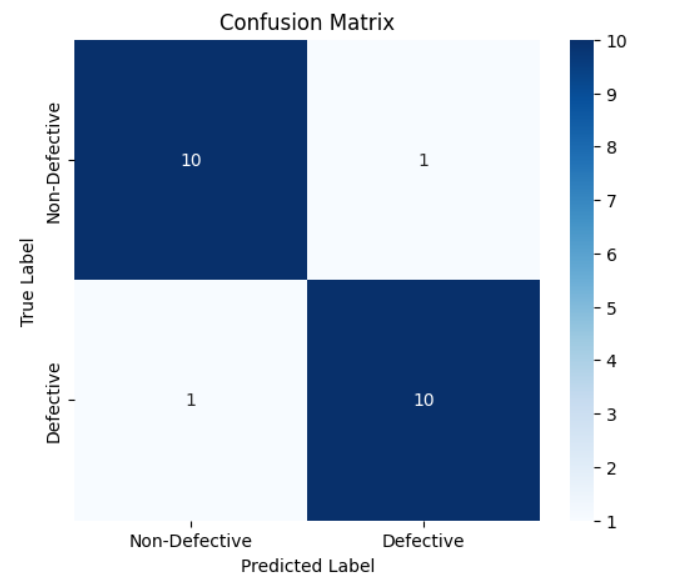

# Model Performance Comparison
The following plot shows the test accuracies of different models trained with data augmentation:
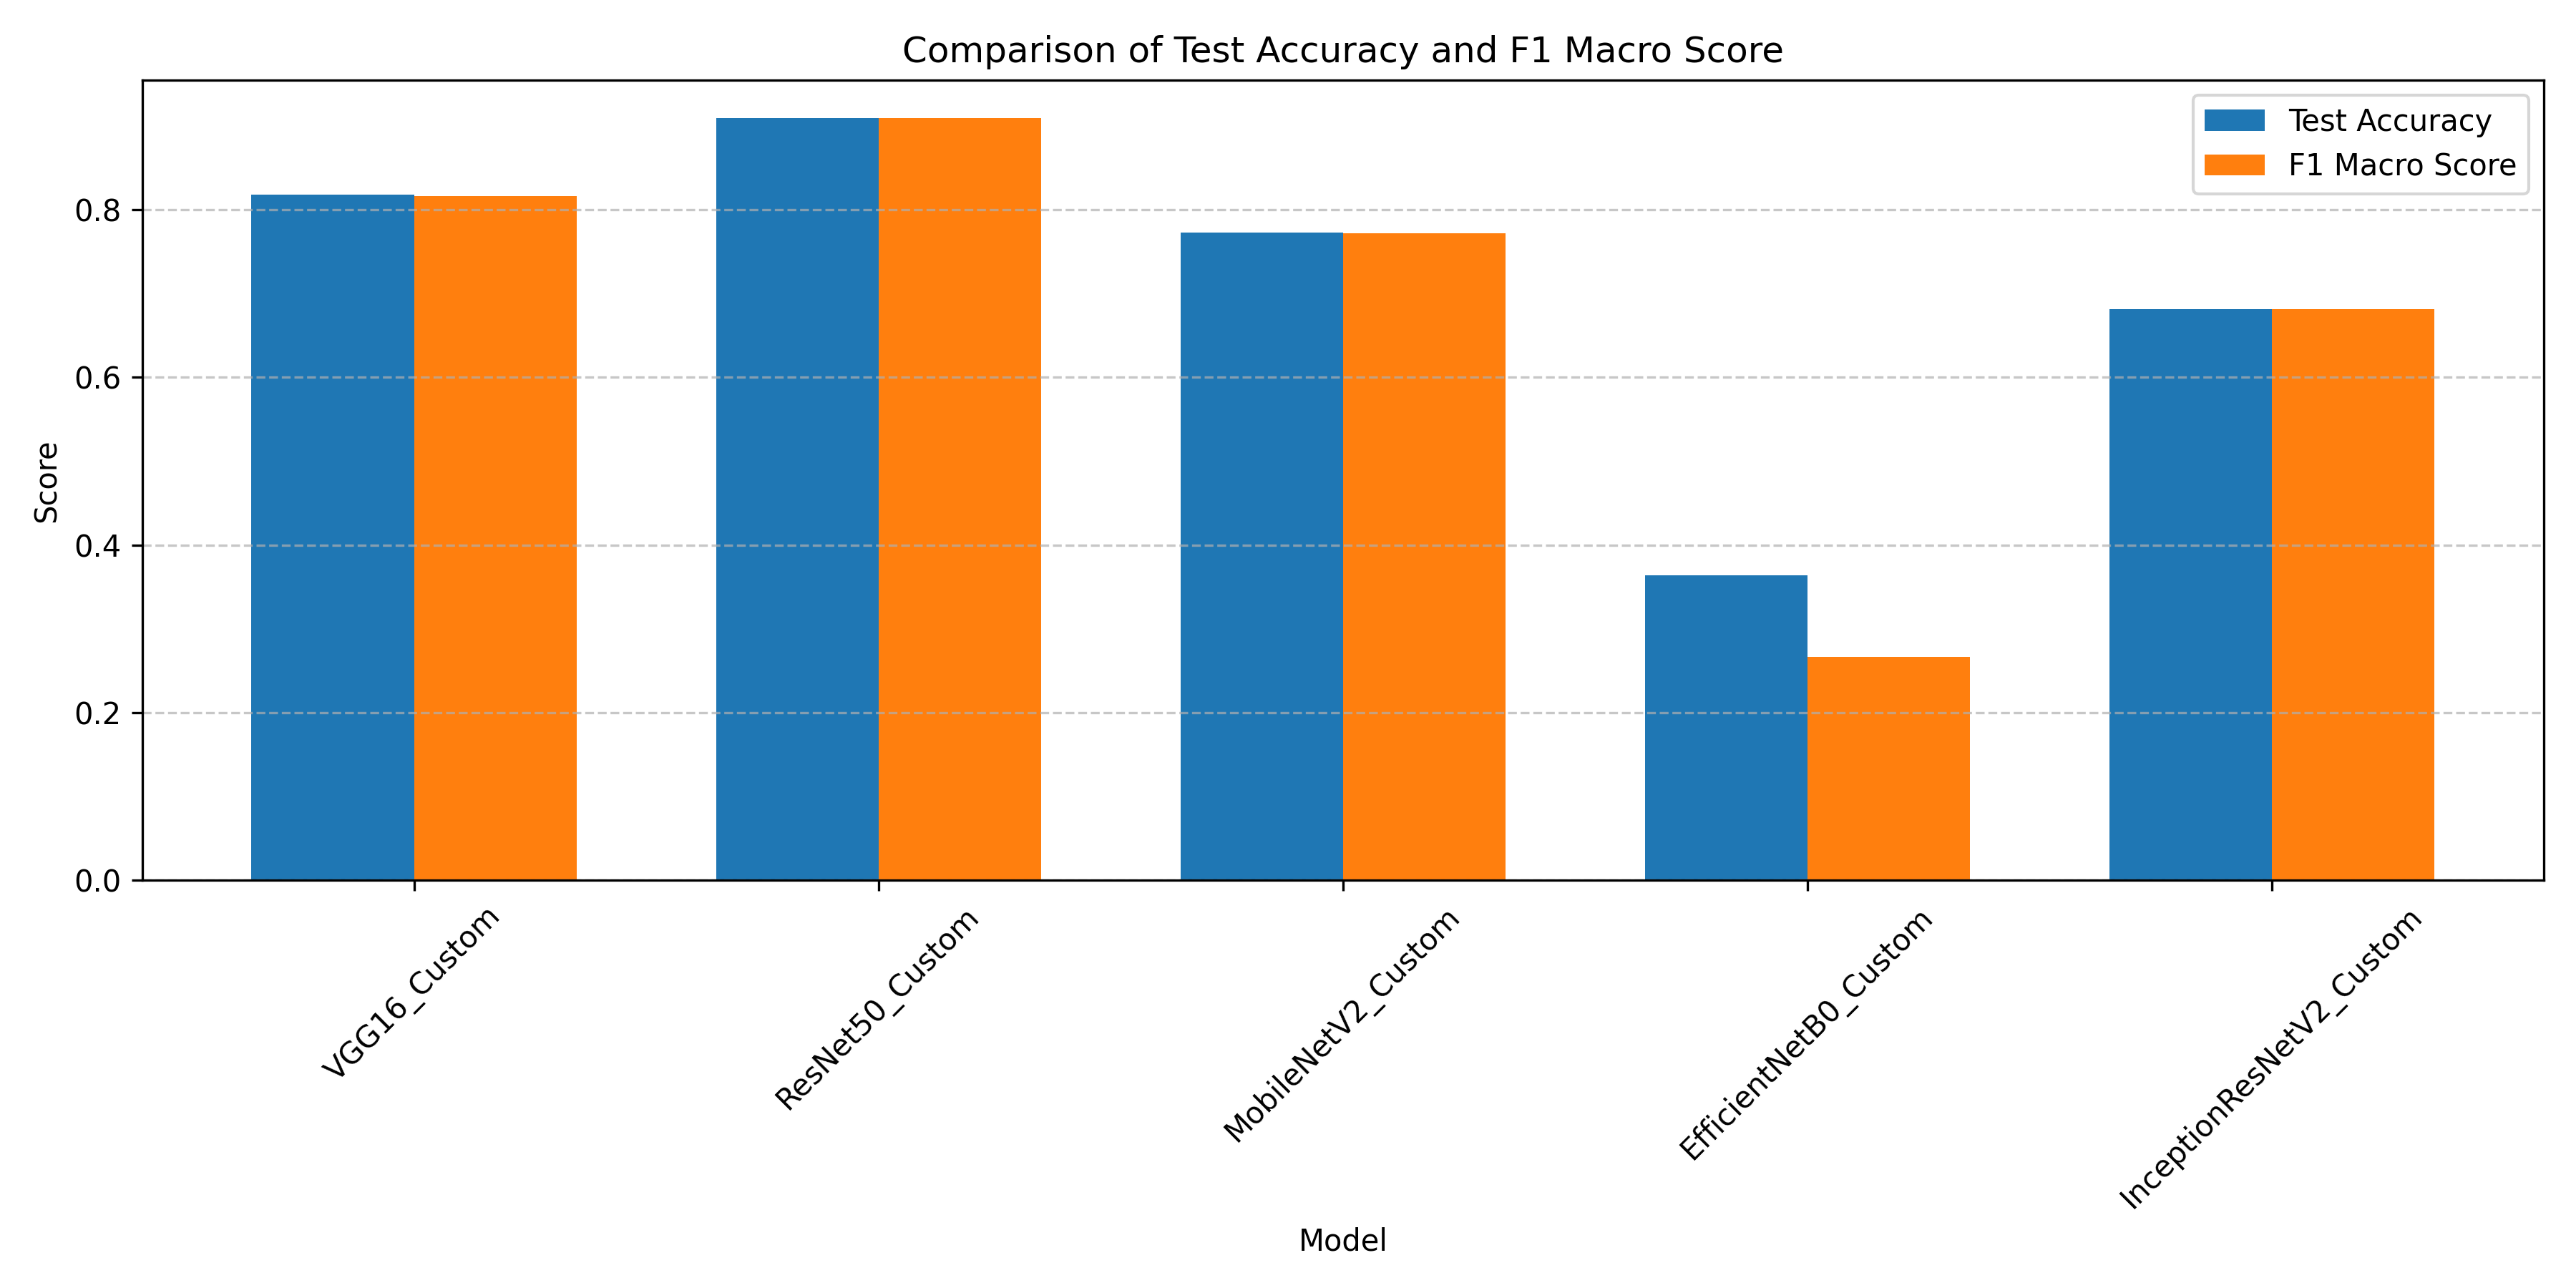


